# Solving the Line Extending Game with Rules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import warnings
import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import CFG
from nltk import PCFG
from nltk.parse.generate import generate
from nltk.tokenize import wordpunct_tokenize
from nltk.parse.recursivedescent import RecursiveDescentParser
from nltk.tree.tree import Tree
from nltk import Nonterminal

from nsai_experiments import line_extending_game_tools as lgt

Taking inspiration from the second human solution, we define a *rule* as a statement of the form "if this list of cells is filled in and this list of cells is not filled in, fill in the central cell." Then a *ruleset* is a list of rules with the semantic "fill in the central cell if any of these rules say to do so." Here, we will develop a context-free grammar that can produce rules, then train an agent to play the game with a ruleset as its policy.

In [3]:
grammar = CFG.fromstring("""
    S -> "if_filled" CellList "and_empty" CellList "then_activate"
    CellList -> "[" Cell "]" CellList |
    Cell -> "R" NonCentralNumber "C" AnyNumber | "R" CentralNumber "C" NonCentralNumber
    AnyNumber -> NonCentralNumber | CentralNumber
    NonCentralNumber -> "0" | "1" | "3" | "4"
    CentralNumber -> "2"
    """)

Note that we have hardcoded the idea that the central cell (R 2 C 2) is invalid, but there is no elegant way (TODO pumping lemma?) to encode in the *grammar* that cells that appear in the "if_filled" list should not appear in the "and_empty" list. In other words, it is possible to have rules that are grammatical but unpragmatic.

In [4]:
some_rules = [" ".join(x) for x in generate(grammar, depth = 6)]
display(some_rules[:5])

['if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 0 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 1 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 3 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 4 ] then_activate',
 'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] then_activate']

This is an LL(1) language, so a recursive descent parser suffices:

In [5]:
my_rule = some_rules[1]
parser = RecursiveDescentParser(grammar)
parsed = parser.parse(wordpunct_tokenize(my_rule))
for x in parsed:
    print(x)

(S
  if_filled
  (CellList
    [
    (Cell R (NonCentralNumber 0) C (AnyNumber (NonCentralNumber 0)))
    ]
    (CellList
      [
      (Cell R (CentralNumber 2) C (NonCentralNumber 0))
      ]
      (CellList )))
  and_empty
  (CellList
    [
    (Cell R (NonCentralNumber 0) C (AnyNumber (NonCentralNumber 0)))
    ]
    (CellList
      [
      (Cell R (CentralNumber 2) C (NonCentralNumber 1))
      ]
      (CellList )))
  then_activate)


Here we parse a rule string into a Python data structure for further use:

In [6]:
def parse_cell(cell: Tree):
    _, row, _, col = cell
    # row, col at this point might be primitive or composite, but in all cases the number is at the end
    return int(row.leaves()[-1]), int(col.leaves()[-1])

def parse_cell_list(cl_tree: Tree):
    if len(cl_tree) == 0: return []
    _, first, _, rest = cl_tree
    return [parse_cell(first)] + parse_cell_list(rest)

def parse_to_python(rule_string):
    root, = parser.parse(wordpunct_tokenize(rule_string))
    _, cl_tree1, _, cl_tree2, _ = root
    return parse_cell_list(cl_tree1), parse_cell_list(cl_tree2)

display(my_rule)
display(parse_to_python(my_rule))

'if_filled [ R 0 C 0 ] [ R 2 C 0 ] and_empty [ R 0 C 0 ] [ R 2 C 1 ] then_activate'

([(0, 0), (2, 0)], [(0, 0), (2, 1)])

To generate rules weighted towards simplicity:

In [7]:
def create_weighted_grammar(decay):
    return PCFG.fromstring(f"""
        S -> "if_filled" CellList "and_empty" CellList "then_activate" [1]
        CellList -> "[" Cell "]" CellList [{decay}] | [{1-decay}]
        Cell -> "R" NonCentralNumber "C" AnyNumber [{20/24}] | "R" CentralNumber "C" NonCentralNumber [{4/24}]
        AnyNumber -> NonCentralNumber [0.8] | CentralNumber [0.2]
        NonCentralNumber -> "0" [0.25] | "1" [0.25] | "3" [0.25] | "4" [0.25]
        CentralNumber -> "2" [1]
        """)

def generate_one_probabilistic(pcfg: PCFG, current_nonterminal = None):
    if current_nonterminal is None: current_nonterminal = pcfg.start()
    current_prods = list(pcfg.productions(lhs = current_nonterminal))
    selected_prod = random.choices(current_prods, weights = [prod.prob() for prod in current_prods])[0]
    result = []
    for fragment in selected_prod.rhs():
        result += generate_one_probabilistic(pcfg, fragment) if isinstance(fragment, Nonterminal) else [fragment]
    return result

for i in range(10):
    print(" ".join(generate_one_probabilistic(create_weighted_grammar(0.75))))

if_filled [ R 0 C 3 ] [ R 4 C 0 ] [ R 3 C 3 ] [ R 0 C 4 ] [ R 4 C 4 ] [ R 1 C 3 ] [ R 0 C 0 ] [ R 4 C 4 ] and_empty then_activate
if_filled [ R 4 C 3 ] and_empty [ R 0 C 3 ] [ R 4 C 3 ] [ R 0 C 2 ] [ R 0 C 4 ] [ R 4 C 2 ] [ R 3 C 1 ] then_activate
if_filled [ R 2 C 3 ] [ R 3 C 4 ] [ R 0 C 3 ] and_empty then_activate
if_filled and_empty [ R 3 C 1 ] [ R 0 C 4 ] then_activate
if_filled and_empty then_activate
if_filled [ R 3 C 0 ] [ R 4 C 2 ] and_empty [ R 1 C 0 ] [ R 0 C 0 ] [ R 3 C 2 ] [ R 3 C 1 ] [ R 0 C 1 ] [ R 2 C 4 ] [ R 3 C 3 ] [ R 1 C 3 ] [ R 0 C 2 ] [ R 4 C 1 ] [ R 2 C 4 ] then_activate
if_filled [ R 2 C 0 ] [ R 4 C 3 ] [ R 3 C 2 ] [ R 1 C 3 ] [ R 0 C 0 ] and_empty then_activate
if_filled [ R 2 C 3 ] [ R 0 C 3 ] [ R 3 C 0 ] [ R 3 C 4 ] and_empty then_activate
if_filled [ R 3 C 3 ] [ R 3 C 4 ] [ R 4 C 4 ] [ R 0 C 3 ] [ R 2 C 1 ] [ R 2 C 4 ] and_empty then_activate
if_filled and_empty [ R 4 C 4 ] [ R 2 C 0 ] [ R 0 C 2 ] [ R 1 C 1 ] [ R 3 C 1 ] [ R 2 C 3 ] [ R 3 C 2 ] then_activate


A bit of hyperparameter pretuning: what is the proportion of rules with two "is_filled" cells and zero "and_empty" cells for various values of `decay`?

0.2
0.225
0.25
0.275
0.3
0.32499999999999996
0.35
0.375
0.39999999999999997
0.42499999999999993
0.44999999999999996
0.475
0.49999999999999994
0.5249999999999999
0.5499999999999999
0.575
0.5999999999999999
0.6249999999999999
0.6499999999999999
0.6749999999999999
0.7
0.7249999999999999
0.7499999999999999
0.7749999999999999
0.7999999999999998


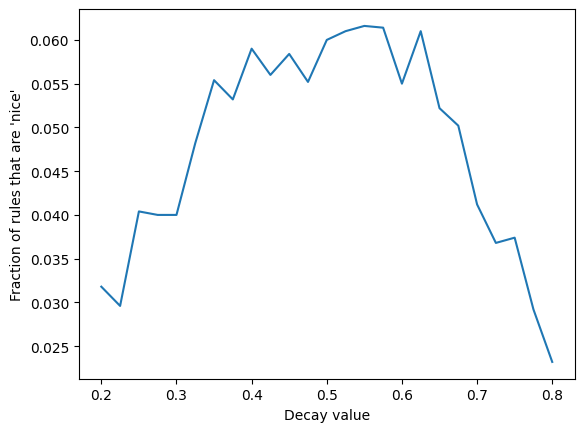

Text(0, 0.5, "Time taken per 'nice' rule")

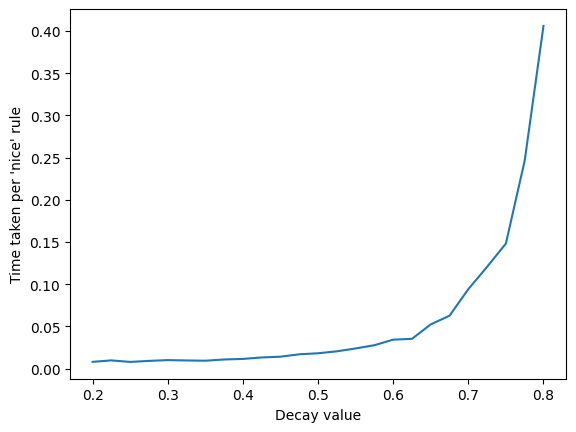

In [9]:
n_to_test = 5000
decay_values = np.arange(0.2, 0.8, 0.025)
times = []
two_zero_occurrences = []
is_two_zero_occurrence = lambda result: len(result[0]) == 2 and len(result[1]) == 0
for decay in decay_values:
    print(decay)
    my_grammar = create_weighted_grammar(decay)
    start = time.perf_counter()
    two_zero_occurrences.append(sum([is_two_zero_occurrence(parse_to_python(" ".join(generate_one_probabilistic(my_grammar)))) for i in range(n_to_test)]))
    end = time.perf_counter()
    times.append(end-start)

plt.plot(decay_values, np.array(two_zero_occurrences)/n_to_test)
plt.xlabel("Decay value")
plt.ylabel("Fraction of rules that are 'nice'")
plt.show()

plt.plot(decay_values, np.array(times)/np.array(two_zero_occurrences))
plt.xlabel("Decay value")
plt.ylabel("Time taken per 'nice' rule")

0.45
0.47500000000000003
0.5
0.5250000000000001
0.55
0.5750000000000002
0.6000000000000001
0.6250000000000002


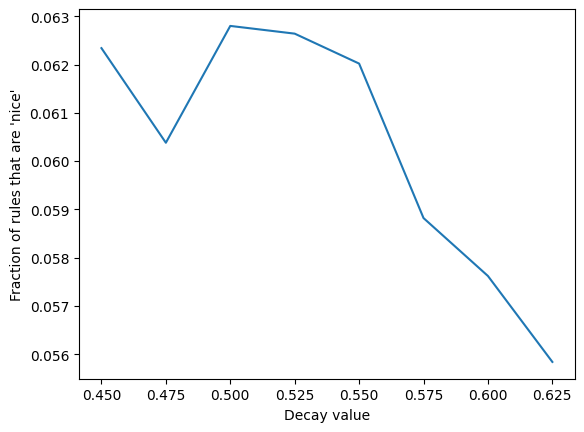

In [11]:
n_to_test = 50_000
decay_values = np.arange(0.45, 0.65, 0.025)
times = []
two_zero_occurrences = []
is_two_zero_occurrence = lambda result: len(result[0]) == 2 and len(result[1]) == 0
for decay in decay_values:
    print(decay)
    my_grammar = create_weighted_grammar(decay)
    start = time.perf_counter()
    two_zero_occurrences.append(sum([is_two_zero_occurrence(parse_to_python(" ".join(generate_one_probabilistic(my_grammar)))) for i in range(n_to_test)]))
    end = time.perf_counter()
    times.append(end-start)

plt.plot(decay_values, np.array(two_zero_occurrences)/n_to_test)
plt.xlabel("Decay value")
plt.ylabel("Fraction of rules that are 'nice'")
plt.show()

In an algorithm where much more time is spent evaluating rules than generating them, we should choose a decay value of around 0.5.